# download VGG model & parameters & flower data set

In [1]:
from urllib.request import urlretrieve # 直接将远程数据下载到本地
from os.path import isfile, isdir  # 判断文件是否存在 / 判断目录是否存在
from tqdm import tqdm  #进度条
import tarfile # 压缩 解压 归档

In [2]:
# 进度条   
class DLProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [3]:
# download VGG16 model
# 手工下载。。。。
# git clone https://github.com/machrisaa/tensorflow-vgg


In [4]:
# download VGG16 parameter
vgg_dir = 'tensorflow_vgg/'

if not isdir(vgg_dir):
    raise Exception("VGG diretory does't exist!")
    
if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve( 
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy', 
             vgg_dir + 'vgg16.npy', 
             pbar.hook)
else:
    print("VGG16 Parameters file alredy exists!")

VGG16 Parameters file alredy exists!


In [5]:
# download Flower Data Set

dataset_folder_path = 'flower_photos'

if not isfile("flower_photos.tar.gz"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flower Data Set') as pbar:
        urlretrieve( 
            'http://download.tensorflow.org/example_images/flower_photos.tgz', 
             'flower_photos.tar.gz', 
             pbar.hook)
else:
    print(" flower_photos.tar.gz  alredy exists!")
    
if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()
else:
    print(" flower_photos alredy exists!")

 flower_photos.tar.gz  alredy exists!
 flower_photos alredy exists!


# 提取 conv code

In [6]:
import tensorflow as tf
import os
import numpy as np
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [35]:
# 定义 输入
#input_ = tf.placeholder(tf.float32, [None, 224, 224, 3], name='input_code')

# 获取 类别
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [class_ for class_ in contents if os.path.isdir(data_dir + class_)]

In [8]:
print (classes)
print (contents)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']


In [9]:
# 在 flower 数据集上运行 特征提取器，获取 conv codes
# pass flower image 到 VGG16，获取 relu的codes
batch_size = 10
batch = []
labels = []

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    
    with tf.name_scope("content_vgg"):
        # 确保整个运行过程只运行一个vgg.buil
        # 只能有1个 否则会将该节点不断加入到graph，最终出现过多的节点，导致重启notebook
        vgg.build(input_)  # 输入 tensor [None, 224, 224, 3]
        
    for class_ in classes:
        print ("Starting {} images".format(class_))
        class_path = data_dir + class_
        img_files = os.listdir(class_path) 
        
        for i, img_file in enumerate(img_files, 1):
            
            # 加载图像到批次上，直接裁剪出 中心部分，直至 224x224 大小
            img = utils.load_image(os.path.join(class_path, img_file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(class_)
            
            if i % batch_size == 0 or i == len(img_files):
                # 将 image batch 传入到 vgg net 
                
                # 数组拼接 将所有的img 放一起
                images = np.concatenate(batch) 
                
                # 从 relu6 layer 获取 value
                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                    
                # reset to start building the next batch
                batch = []
                print('{} images processed'.format(i))
                
                

D:\Udacity\DL_Test\Test_DL_C3\Test_DL_C3_L12_transfer-learning\test\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting daisy images
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images pro

In [10]:
import csv
# 保存labels
with open('save_feature/labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

# 保存 codes
with open('save_feature/codes', 'w') as f:
    codes.tofile(f)

#### cheakpoint

In [1]:
import csv
import numpy as np
# 加载 labels
with open('save_feature/labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()

# 加载 codes
with open('save_feature/codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    print (codes.shape)
    print (len(labels))
    codes = codes.reshape((len(labels), -1))

print (codes.shape)

(15032320,)
3670
(3670, 4096)


# 预处理 Preprocessing

In [2]:
# labels 转成 one-hot encode
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
labels_enc = lb.fit_transform(labels)

In [13]:
print (labels)
print (len(labels))

['daisy' 'daisy' 'daisy' ..., 'tulips' 'tulips' 'tulips']
3670


In [3]:
# 拆分 数据集为 train | validation | test
from sklearn.model_selection import StratifiedShuffleSplit

# 因不同类别分别放在不同文件夹，
# 需通过随机化，使所有的类均匀分布在train/val/test的数据集中

# 返回 生成器
# n_splits=1 拆分数量，即想要多少种不同的方式来拆分和整理数据
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2,  random_state=0)

# sss.split -->返回索引   next --> 获取索引
train_idx, val_idx = next(sss.split(codes, labels))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_enc[train_idx]
val_x, val_y = codes[val_idx], labels_enc[val_idx]
test_x, test_y = codes[test_idx], labels_enc[test_idx]
    

In [15]:
# 检查 拆分结果
print ("train set shapes (x, y): ",train_x.shape, train_y.shape)
print ("validation set shapes (x, y): ",val_x.shape, val_y.shape)
print ("test set shapes (x, y): ",test_x.shape, test_y.shape)
print (len(labels) == train_y.shape[0] + val_y.shape[0] + test_y.shape[0])


train set shapes (x, y):  (2936, 4096) (2936, 5)
validation set shapes (x, y):  (367, 4096) (367, 5)
test set shapes (x, y):  (367, 4096) (367, 5)
True


# 定义 Neoral Network

In [3]:
import tensorflow as tf

#定义 placeholder
input_ = tf.placeholder(tf.float32, [None, codes.shape[1]], name='input')
target = tf.placeholder(tf.int64, [None, labels_enc.shape[1]], name='target')

# 定义 分类器 layers
import tensorflow as tf

#fc = tf.layers.dense(input_, 1024)
#logits = tf.layers.dense(fc, labels_enc.shape[1], activation=None)
fc = tf.contrib.layers.fully_connected(input_,  256)
logits = tf.contrib.layers.fully_connected(fc, labels_enc.shape[1], activation_fn = None)

# 定义 损失
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, 
                                                              labels=target))
# 定义 优化器
optimizer = tf.train.AdamOptimizer().minimize(cost)

# 定义 准确率
predicted = tf.nn.softmax(logits)
accuracy_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(target, 1))
accuracy = tf.reduce_mean(tf.cast(accuracy_pred, tf.float32))

In [17]:
# 定义 full batch
def get_batches(x, y, n_batches=10):

    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # 如果不在最后一个batch 
        # 则 直接 按照 batch_size 获取数据
        # 否则 取剩下的数据
        if ii != (n_batches -1) * batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size]
        else:
            X, Y = x[ii:], y[ii:]
        yield X, Y

In [18]:
# 设置 Hyperparameters
#learning_rate = 0.001
n_batches = 10
epochs = 2

# train

In [27]:
saver = tf.train.Saver()

print ('Running....')
iteration = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):

        # 训练 更新 获取loss 
        for x, y in get_batches(train_x, train_y, n_batches):
            train_feed_dict = {input_:x, 
                               target:y}
            train_cost, _ = sess.run([cost, optimizer], 
                                     feed_dict = train_feed_dict)

            print("Epoch: {}/{}".format(e+1, epochs),
                   "Iteration: {}".format(iteration),
                   "Training cost: {:.5f}".format(train_cost))
            iteration += 1

            # 获取 val 的准确度
            if iteration % 5 == 0:
                val_feed_dict = {input_:val_x, 
                                 target:val_y} 
                val_accuracy = sess.run(accuracy, 
                                        feed_dict = val_feed_dict)
                print ("Epoch: {}/{}".format(e+1, epochs),
                       "Iteration: {}".format(iteration),
                       "Valitation accuracy: {:.5f} \n\n".format(val_accuracy))            
        

    saver.save(sess, "checkpoints/flowers.ckpt")

Running....
Epoch: 1/2 Iteration: 0 Training cost: 5.66756
Epoch: 1/2 Iteration: 1 Training cost: 14.43206
Epoch: 1/2 Iteration: 2 Training cost: 7.47497
Epoch: 1/2 Iteration: 3 Training cost: 3.20901
Epoch: 1/2 Iteration: 4 Training cost: 5.72045
Epoch: 1/2 Iteration: 5 Valitation accuracy: 0.66757 


Epoch: 1/2 Iteration: 5 Training cost: 4.46825
Epoch: 1/2 Iteration: 6 Training cost: 1.32182
Epoch: 1/2 Iteration: 7 Training cost: 1.77860
Epoch: 1/2 Iteration: 8 Training cost: 2.83687
Epoch: 1/2 Iteration: 9 Training cost: 1.86234
Epoch: 1/2 Iteration: 10 Valitation accuracy: 0.77112 


Epoch: 2/2 Iteration: 10 Training cost: 1.36646
Epoch: 2/2 Iteration: 11 Training cost: 1.01592
Epoch: 2/2 Iteration: 12 Training cost: 1.13028
Epoch: 2/2 Iteration: 13 Training cost: 1.09343
Epoch: 2/2 Iteration: 14 Training cost: 0.70122
Epoch: 2/2 Iteration: 15 Valitation accuracy: 0.79837 


Epoch: 2/2 Iteration: 15 Training cost: 0.84924
Epoch: 2/2 Iteration: 16 Training cost: 0.53747
Epoch: 2/2 

# test

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed_dict = {input_:test_x,
                 target:test_y}
    test_accuracy = sess.run(accuracy, feed_dict=feed_dict)
    print ("Accuracy:  {:.5f}".format(test_accuracy))

Accuracy:  0.82289


# 可视化

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

import tensorflow as tf
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

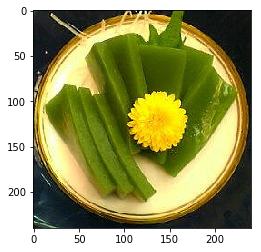

In [5]:
test_img_path = 'flower_photos/dandelion/7355522_b66e5d3078_m.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [6]:
# 判断是否存在 vgg graph build，如果没有，则创建一个  
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    # create vgg build
    with tf.Session() as sess:
        input_code = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_code)

D:\Udacity\DL_Test\Test_DL_C3\Test_DL_C3_L12_transfer-learning\test\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [7]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    print (img.shape)
    img = img.reshape((1, 224, 224, 3))
    print (img.shape)
    feed_dict = {input_code: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
    print (code.shape)
  
    
    
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    code = code.reshape((1, -1))
    feed = {input_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

(224, 224, 3)
(1, 224, 224, 3)
(1, 4096)


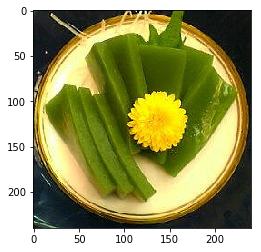

In [11]:
plt.imshow(test_img)

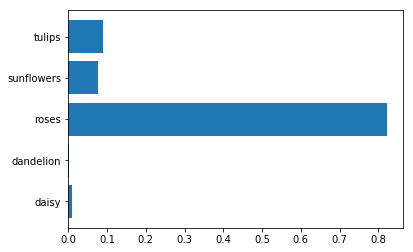

In [10]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)